In [1]:
import multiprocessing as mp
mp.set_start_method('spawn', force=True)

In [2]:
import os
os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":4096:8"
# os.environ["CUDA_LAUNCH_BLOCKING"] = "1"
import logging
import torch
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

from torch.utils.data import DataLoader, Subset
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.amp import autocast, GradScaler
from models.diff_modules import diff_CSDI
from models.diff_model import DiffusionTrajectoryModel
from models.encoder import InteractionGraphEncoder, TargetTrajectoryEncoder
from make_dataset import MultiMatchSoccerDataset, organize_and_process
from utils.utils import set_evertyhing, worker_init_fn, generator, plot_trajectories_on_pitch, log_graph_stats
from utils.data_utils import split_dataset_indices, custom_collate_fn
from utils.graph_utils import build_graph_sequence_from_condition

# SEED Fix
SEED = 42
set_evertyhing(SEED)


# Save Log / Logger Setting
model_save_path = './results/logs/'
os.makedirs(model_save_path, exist_ok=True)
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s %(levelname)s %(message)s',
    filename=os.path.join(model_save_path, 'train.log'),
    filemode='w'
)
logger = logging.getLogger()

# 1. Model Config & Hyperparameter Setting
csdi_config = {
    "num_steps": 1000,
    "channels": 256,
    "diffusion_embedding_dim": 256,
    "nheads": 4,
    "layers": 5,
    # "side_dim": 128
    "side_dim": 512
}
hyperparams = {
    'raw_data_path': "idsse-data", # raw_data_path = "Download raw file path"
    'data_save_path': "match_data",
    'train_batch_size': 16,
    'val_batch_size': 16,
    'test_batch_size': 16,
    'num_workers': 8,
    'epochs': 50,
    'learning_rate': 1e-4,
    'self_conditioning_ratio': 0.5,
    'num_samples': 10,
    'device': 'cuda:1' if torch.cuda.is_available() else 'cpu',

    'ddim_step': 200,
    'eta': 0.1,
    **csdi_config
}
raw_data_path = hyperparams['raw_data_path']
data_save_path = hyperparams['data_save_path']
train_batch_size = hyperparams['train_batch_size']
val_batch_size = hyperparams['val_batch_size']
test_batch_size = hyperparams['test_batch_size']
num_workers = hyperparams['num_workers']
epochs = hyperparams['epochs']
learning_rate = hyperparams['learning_rate']
self_conditioning_ratio = hyperparams['self_conditioning_ratio']
num_samples = hyperparams['num_samples']
device = hyperparams['device']
ddim_step = hyperparams['ddim_step']
eta = hyperparams['eta']
side_dim = hyperparams['side_dim']

logger.info(f"Hyperparameters: {hyperparams}")

# 2. Data Loading
print("---Data Loading---")
if not os.path.exists(data_save_path) or len(os.listdir(data_save_path)) == 0:
    organize_and_process(raw_data_path, data_save_path)
else:
    print("Skip organize_and_process")

dataset = MultiMatchSoccerDataset(data_root=data_save_path)
train_idx, val_idx, test_idx = split_dataset_indices(dataset, val_ratio=1/6, test_ratio=1/6, random_seed=SEED)

train_dataloader = DataLoader(
    Subset(dataset, train_idx),
    batch_size=train_batch_size,
    shuffle=True,
    num_workers=num_workers,
    pin_memory=True,
    persistent_workers=False,
    collate_fn=custom_collate_fn,
    worker_init_fn=worker_init_fn,
    generator=generator(SEED)
)

val_dataloader = DataLoader(
    Subset(dataset, val_idx),
    batch_size=val_batch_size,
    shuffle=False,
    num_workers=num_workers,
    pin_memory=True,
    persistent_workers=False,
    collate_fn=custom_collate_fn,
    worker_init_fn=worker_init_fn,
)

test_dataloader = DataLoader(
    Subset(dataset, test_idx),
    batch_size=test_batch_size,
    shuffle=False,
    num_workers=num_workers,
    pin_memory=True,
    persistent_workers=False,
    collate_fn=custom_collate_fn,
    worker_init_fn=worker_init_fn
)

print("---Data Load!---")

# 3. Model Define
# Extract node feature dimension
sample = dataset[0]
graph = build_graph_sequence_from_condition({
    "condition": sample["condition"],
    "condition_columns": sample["condition_columns"],
    "pitch_scale": sample["pitch_scale"]
}).to(device)

log_graph_stats(graph, logger, prefix="InitGraphSample")

in_dim = graph['Node'].x.size(1)

# Extract target's history trajectories from condition
condition_columns = sample["condition_columns"]
target_columns = sample["target_columns"]
target_idx = [condition_columns.index(col) for col in target_columns if col in condition_columns]

# graph_encoder = InteractionGraphEncoder(in_dim=in_dim, hidden_dim=128, out_dim=128, heads = 2).to(device)
graph_encoder = InteractionGraphEncoder(in_dim=in_dim, hidden_dim=side_dim // 2, out_dim=side_dim // 2).to(device)
history_encoder = TargetTrajectoryEncoder(num_layers=5, hidden_dim = side_dim // 4, bidirectional=True).to(device)
denoiser = diff_CSDI(csdi_config)
model = DiffusionTrajectoryModel(denoiser, num_steps=csdi_config["num_steps"]).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2, threshold=1e-4)
scaler = GradScaler()

logger.info(f"Device: {device}")
logger.info(f"GraphEncoder: {graph_encoder}")
logger.info(f"HistoryEncoder: {history_encoder}")
logger.info(f"Denoiser (diff_CSDI): {denoiser}")
logger.info(f"DiffusionTrajectoryModel: {model}")

---Data Loading---
Skip organize_and_process


Loading Matches: 100%|██████████| 6/6 [00:40<00:00,  6.70s/it]


---Data Load!---


Training...:   0%|          | 0/50 [00:00<?, ?it/s]

Batch Training...:   0%|          | 0/264 [00:55<?, ?it/s]

Validation:   0%|          | 0/77 [00:57<?, ?it/s]

[Epoch 1]
[Train] Cost: 1.078073 | Noise Loss: 0.405642 | NLL Loss: 0.004985 | Frechet: 0.667446 | LR: 0.000100
[Validation] Val Loss: 0.539586 | Noise Loss: 0.280754 | NLL Loss: 0.004104 | Frechet: 0.254728 |


Batch Training...:   0%|          | 0/264 [00:59<?, ?it/s]

Validation:   0%|          | 0/77 [00:57<?, ?it/s]

[Epoch 2]
[Train] Cost: 0.516443 | Noise Loss: 0.233599 | NLL Loss: 0.003546 | Frechet: 0.279298 | LR: 0.000100
[Validation] Val Loss: 0.425497 | Noise Loss: 0.235646 | NLL Loss: 0.003442 | Frechet: 0.186409 |


Batch Training...:   0%|          | 0/264 [00:57<?, ?it/s]

Validation:   0%|          | 0/77 [00:57<?, ?it/s]

[Epoch 3]
[Train] Cost: 0.443321 | Noise Loss: 0.205905 | NLL Loss: 0.003062 | Frechet: 0.234353 | LR: 0.000100
[Validation] Val Loss: 0.410368 | Noise Loss: 0.215527 | NLL Loss: 0.003031 | Frechet: 0.191811 |


Batch Training...:   0%|          | 0/264 [00:57<?, ?it/s]

Validation:   0%|          | 0/77 [00:56<?, ?it/s]

[Epoch 4]
[Train] Cost: 0.395765 | Noise Loss: 0.178842 | NLL Loss: 0.002571 | Frechet: 0.214352 | LR: 0.000100
[Validation] Val Loss: 0.395543 | Noise Loss: 0.205859 | NLL Loss: 0.002830 | Frechet: 0.186854 |


Batch Training...:   0%|          | 0/264 [00:57<?, ?it/s]

Validation:   0%|          | 0/77 [00:56<?, ?it/s]

[Epoch 5]
[Train] Cost: 0.381127 | Noise Loss: 0.162186 | NLL Loss: 0.002173 | Frechet: 0.216768 | LR: 0.000100
[Validation] Val Loss: 0.354379 | Noise Loss: 0.191469 | NLL Loss: 0.002436 | Frechet: 0.160475 |


Batch Training...:   0%|          | 0/264 [00:56<?, ?it/s]

Validation:   0%|          | 0/77 [00:58<?, ?it/s]

[Epoch 6]
[Train] Cost: 0.329146 | Noise Loss: 0.143983 | NLL Loss: 0.001665 | Frechet: 0.183497 | LR: 0.000100
[Validation] Val Loss: 0.333537 | Noise Loss: 0.176371 | NLL Loss: 0.002058 | Frechet: 0.155107 |


Batch Training...:   0%|          | 0/264 [01:05<?, ?it/s]

Validation:   0%|          | 0/77 [00:55<?, ?it/s]

[Epoch 7]
[Train] Cost: 0.305514 | Noise Loss: 0.128086 | NLL Loss: 0.001184 | Frechet: 0.176245 | LR: 0.000100
[Validation] Val Loss: 0.329529 | Noise Loss: 0.179258 | NLL Loss: 0.001917 | Frechet: 0.148354 |


Batch Training...:   0%|          | 0/264 [00:58<?, ?it/s]

Validation:   0%|          | 0/77 [00:57<?, ?it/s]

[Epoch 8]
[Train] Cost: 0.281806 | Noise Loss: 0.119992 | NLL Loss: 0.000815 | Frechet: 0.160999 | LR: 0.000100
[Validation] Val Loss: 0.299379 | Noise Loss: 0.156116 | NLL Loss: 0.001302 | Frechet: 0.141962 |


Batch Training...:   0%|          | 0/264 [00:57<?, ?it/s]

Validation:   0%|          | 0/77 [00:57<?, ?it/s]

[Epoch 9]
[Train] Cost: 0.270098 | Noise Loss: 0.115146 | NLL Loss: 0.000510 | Frechet: 0.154442 | LR: 0.000100
[Validation] Val Loss: 0.306151 | Noise Loss: 0.149985 | NLL Loss: 0.001147 | Frechet: 0.155019 |


Batch Training...:   0%|          | 0/264 [00:56<?, ?it/s]

Validation:   0%|          | 0/77 [00:57<?, ?it/s]

[Epoch 10]
[Train] Cost: 0.268755 | Noise Loss: 0.114442 | NLL Loss: 0.000367 | Frechet: 0.153945 | LR: 0.000100
[Validation] Val Loss: 0.310983 | Noise Loss: 0.161083 | NLL Loss: 0.001093 | Frechet: 0.148807 |


Batch Training...:   0%|          | 0/264 [00:57<?, ?it/s]

Validation:   0%|          | 0/77 [00:57<?, ?it/s]

[Epoch 11]
[Train] Cost: 0.244748 | Noise Loss: 0.104702 | NLL Loss: 0.000082 | Frechet: 0.139964 | LR: 0.000100
[Validation] Val Loss: 0.268579 | Noise Loss: 0.148501 | NLL Loss: 0.000568 | Frechet: 0.119510 |


Batch Training...:   0%|          | 0/264 [00:57<?, ?it/s]

Validation:   0%|          | 0/77 [01:00<?, ?it/s]

[Epoch 12]
[Train] Cost: 0.240334 | Noise Loss: 0.102231 | NLL Loss: -0.000054 | Frechet: 0.138157 | LR: 0.000100
[Validation] Val Loss: 0.254398 | Noise Loss: 0.132809 | NLL Loss: 0.000247 | Frechet: 0.121341 |


Batch Training...:   0%|          | 0/264 [00:55<?, ?it/s]

Validation:   0%|          | 0/77 [00:56<?, ?it/s]

[Epoch 13]
[Train] Cost: 0.232464 | Noise Loss: 0.103560 | NLL Loss: -0.000147 | Frechet: 0.129051 | LR: 0.000100
[Validation] Val Loss: 0.266589 | Noise Loss: 0.149585 | NLL Loss: 0.000425 | Frechet: 0.116579 |


Batch Training...:   0%|          | 0/264 [00:55<?, ?it/s]

Validation:   0%|          | 0/77 [00:56<?, ?it/s]

[Epoch 14]
[Train] Cost: 0.232680 | Noise Loss: 0.102743 | NLL Loss: -0.000240 | Frechet: 0.130177 | LR: 0.000100
[Validation] Val Loss: 0.249431 | Noise Loss: 0.140124 | NLL Loss: 0.000596 | Frechet: 0.108711 |


Batch Training...:   0%|          | 0/264 [00:58<?, ?it/s]

Validation:   0%|          | 0/77 [00:56<?, ?it/s]

[Epoch 15]
[Train] Cost: 0.216935 | Noise Loss: 0.098763 | NLL Loss: -0.000420 | Frechet: 0.118593 | LR: 0.000100
[Validation] Val Loss: 0.242594 | Noise Loss: 0.137673 | NLL Loss: 0.000171 | Frechet: 0.104751 |


Batch Training...:   0%|          | 0/264 [00:58<?, ?it/s]

Validation:   0%|          | 0/77 [00:58<?, ?it/s]

[Epoch 16]
[Train] Cost: 0.213788 | Noise Loss: 0.096676 | NLL Loss: -0.000552 | Frechet: 0.117665 | LR: 0.000100
[Validation] Val Loss: 0.236991 | Noise Loss: 0.131000 | NLL Loss: 0.000222 | Frechet: 0.105769 |


Batch Training...:   0%|          | 0/264 [01:01<?, ?it/s]

Validation:   0%|          | 0/77 [00:55<?, ?it/s]

[Epoch 17]
[Train] Cost: 0.210470 | Noise Loss: 0.090958 | NLL Loss: -0.000680 | Frechet: 0.120192 | LR: 0.000100
[Validation] Val Loss: 0.241345 | Noise Loss: 0.125907 | NLL Loss: -0.000226 | Frechet: 0.115664 |


Batch Training...:   0%|          | 0/264 [00:58<?, ?it/s]

Validation:   0%|          | 0/77 [00:57<?, ?it/s]

[Epoch 18]
[Train] Cost: 0.205666 | Noise Loss: 0.088315 | NLL Loss: -0.000810 | Frechet: 0.118161 | LR: 0.000100
[Validation] Val Loss: 0.242739 | Noise Loss: 0.135564 | NLL Loss: 0.000224 | Frechet: 0.106952 |


Batch Training...:   0%|          | 0/264 [00:59<?, ?it/s]

Validation:   0%|          | 0/77 [00:57<?, ?it/s]

[Epoch 19]
[Train] Cost: 0.197972 | Noise Loss: 0.088977 | NLL Loss: -0.000947 | Frechet: 0.109942 | LR: 0.000100
[Validation] Val Loss: 0.234978 | Noise Loss: 0.138570 | NLL Loss: 0.000235 | Frechet: 0.096173 |


Batch Training...:   0%|          | 0/264 [00:58<?, ?it/s]

Validation:   0%|          | 0/77 [00:56<?, ?it/s]

[Epoch 20]
[Train] Cost: 0.196596 | Noise Loss: 0.086992 | NLL Loss: -0.001057 | Frechet: 0.110662 | LR: 0.000100
[Validation] Val Loss: 0.227360 | Noise Loss: 0.130788 | NLL Loss: -0.000261 | Frechet: 0.096833 |


Batch Training...:   0%|          | 0/264 [00:58<?, ?it/s]

Validation:   0%|          | 0/77 [00:55<?, ?it/s]

[Epoch 21]
[Train] Cost: 0.192956 | Noise Loss: 0.084194 | NLL Loss: -0.001177 | Frechet: 0.109939 | LR: 0.000100
[Validation] Val Loss: 0.226014 | Noise Loss: 0.131825 | NLL Loss: -0.000509 | Frechet: 0.094697 |


Batch Training...:   0%|          | 0/264 [00:57<?, ?it/s]

Validation:   0%|          | 0/77 [00:57<?, ?it/s]

[Epoch 22]
[Train] Cost: 0.185912 | Noise Loss: 0.083090 | NLL Loss: -0.001200 | Frechet: 0.104022 | LR: 0.000100
[Validation] Val Loss: 0.229319 | Noise Loss: 0.128023 | NLL Loss: 0.000113 | Frechet: 0.101183 |


Batch Training...:   0%|          | 0/264 [00:56<?, ?it/s]

Validation:   0%|          | 0/77 [00:57<?, ?it/s]

[Epoch 23]
[Train] Cost: 0.184258 | Noise Loss: 0.084037 | NLL Loss: -0.001273 | Frechet: 0.101494 | LR: 0.000100
[Validation] Val Loss: 0.248232 | Noise Loss: 0.130115 | NLL Loss: 0.000221 | Frechet: 0.117896 |


Batch Training...:   0%|          | 0/264 [00:57<?, ?it/s]

Validation:   0%|          | 0/77 [00:57<?, ?it/s]

[Epoch 24]
[Train] Cost: 0.175631 | Noise Loss: 0.079358 | NLL Loss: -0.001374 | Frechet: 0.097647 | LR: 0.000100
[Validation] Val Loss: 0.213056 | Noise Loss: 0.125389 | NLL Loss: -0.000428 | Frechet: 0.088095 |


Batch Training...:   0%|          | 0/264 [00:56<?, ?it/s]

Validation:   0%|          | 0/77 [00:54<?, ?it/s]

[Epoch 25]
[Train] Cost: 0.175329 | Noise Loss: 0.082759 | NLL Loss: -0.001287 | Frechet: 0.093857 | LR: 0.000100
[Validation] Val Loss: 0.221346 | Noise Loss: 0.132899 | NLL Loss: -0.000256 | Frechet: 0.088703 |


Batch Training...:   0%|          | 0/264 [00:57<?, ?it/s]

Validation:   0%|          | 0/77 [00:57<?, ?it/s]

[Epoch 26]
[Train] Cost: 0.170589 | Noise Loss: 0.078897 | NLL Loss: -0.001578 | Frechet: 0.093269 | LR: 0.000100
[Validation] Val Loss: 0.215646 | Noise Loss: 0.127925 | NLL Loss: -0.000396 | Frechet: 0.088118 |


Batch Training...:   0%|          | 0/264 [00:56<?, ?it/s]

Validation:   0%|          | 0/77 [00:57<?, ?it/s]

[Epoch 27]
[Train] Cost: 0.173550 | Noise Loss: 0.077973 | NLL Loss: -0.001503 | Frechet: 0.097080 | LR: 0.000100
[Validation] Val Loss: 0.214404 | Noise Loss: 0.128374 | NLL Loss: -0.000576 | Frechet: 0.086606 |


Batch Training...:   0%|          | 0/264 [00:58<?, ?it/s]

Validation:   0%|          | 0/77 [00:56<?, ?it/s]

[Epoch 28]
[Train] Cost: 0.153590 | Noise Loss: 0.075034 | NLL Loss: -0.001823 | Frechet: 0.080378 | LR: 0.000050
[Validation] Val Loss: 0.215244 | Noise Loss: 0.131516 | NLL Loss: -0.000544 | Frechet: 0.084271 |


Batch Training...:   0%|          | 0/264 [00:57<?, ?it/s]

Validation:   0%|          | 0/77 [00:56<?, ?it/s]

[Epoch 29]
[Train] Cost: 0.149751 | Noise Loss: 0.071022 | NLL Loss: -0.001990 | Frechet: 0.080719 | LR: 0.000050
[Validation] Val Loss: 0.205114 | Noise Loss: 0.120787 | NLL Loss: -0.000559 | Frechet: 0.084886 |


Batch Training...:   0%|          | 0/264 [00:55<?, ?it/s]

Validation:   0%|          | 0/77 [00:57<?, ?it/s]

[Epoch 30]
[Train] Cost: 0.145682 | Noise Loss: 0.070717 | NLL Loss: -0.002127 | Frechet: 0.077092 | LR: 0.000050
[Validation] Val Loss: 0.208553 | Noise Loss: 0.130850 | NLL Loss: -0.000172 | Frechet: 0.077875 |


Batch Training...:   0%|          | 0/264 [00:55<?, ?it/s]

Validation:   0%|          | 0/77 [00:57<?, ?it/s]

[Epoch 31]
[Train] Cost: 0.148794 | Noise Loss: 0.071954 | NLL Loss: -0.002048 | Frechet: 0.078887 | LR: 0.000050
[Validation] Val Loss: 0.211425 | Noise Loss: 0.129969 | NLL Loss: -0.000581 | Frechet: 0.082037 |


Batch Training...:   0%|          | 0/264 [00:55<?, ?it/s]

Validation:   0%|          | 0/77 [00:55<?, ?it/s]

[Epoch 32]
[Train] Cost: 0.147298 | Noise Loss: 0.071758 | NLL Loss: -0.002127 | Frechet: 0.077668 | LR: 0.000050
[Validation] Val Loss: 0.206250 | Noise Loss: 0.132004 | NLL Loss: -0.000544 | Frechet: 0.074791 |


Batch Training...:   0%|          | 0/264 [00:56<?, ?it/s]

Validation:   0%|          | 0/77 [00:57<?, ?it/s]

[Epoch 33]
[Train] Cost: 0.139020 | Noise Loss: 0.068314 | NLL Loss: -0.002330 | Frechet: 0.073036 | LR: 0.000025
[Validation] Val Loss: 0.206913 | Noise Loss: 0.132524 | NLL Loss: -0.000589 | Frechet: 0.074978 |


Batch Training...:   0%|          | 0/264 [00:58<?, ?it/s]

Validation:   0%|          | 0/77 [00:56<?, ?it/s]

[Epoch 34]
[Train] Cost: 0.137659 | Noise Loss: 0.069953 | NLL Loss: -0.002247 | Frechet: 0.069953 | LR: 0.000025
[Validation] Val Loss: 0.202951 | Noise Loss: 0.128229 | NLL Loss: -0.001053 | Frechet: 0.075775 |


Batch Training...:   0%|          | 0/264 [00:58<?, ?it/s]

Validation:   0%|          | 0/77 [00:56<?, ?it/s]

[Epoch 35]
[Train] Cost: 0.137013 | Noise Loss: 0.070198 | NLL Loss: -0.002304 | Frechet: 0.069119 | LR: 0.000025
[Validation] Val Loss: 0.197643 | Noise Loss: 0.124388 | NLL Loss: -0.000657 | Frechet: 0.073912 |


Batch Training...:   0%|          | 0/264 [00:57<?, ?it/s]

Validation:   0%|          | 0/77 [00:58<?, ?it/s]

[Epoch 36]
[Train] Cost: 0.134432 | Noise Loss: 0.068879 | NLL Loss: -0.002394 | Frechet: 0.067947 | LR: 0.000025
[Validation] Val Loss: 0.195589 | Noise Loss: 0.124597 | NLL Loss: -0.000650 | Frechet: 0.071642 |


Batch Training...:   0%|          | 0/264 [00:56<?, ?it/s]

Validation:   0%|          | 0/77 [00:56<?, ?it/s]

[Epoch 37]
[Train] Cost: 0.135451 | Noise Loss: 0.069014 | NLL Loss: -0.002469 | Frechet: 0.068906 | LR: 0.000025
[Validation] Val Loss: 0.187271 | Noise Loss: 0.112759 | NLL Loss: -0.001122 | Frechet: 0.075634 |


Batch Training...:   0%|          | 0/264 [00:57<?, ?it/s]

Validation:   0%|          | 0/77 [00:56<?, ?it/s]

[Epoch 38]
[Train] Cost: 0.132116 | Noise Loss: 0.067044 | NLL Loss: -0.002460 | Frechet: 0.067531 | LR: 0.000025
[Validation] Val Loss: 0.196546 | Noise Loss: 0.124552 | NLL Loss: -0.000861 | Frechet: 0.072855 |


Batch Training...:   0%|          | 0/264 [00:58<?, ?it/s]

Validation:   0%|          | 0/77 [00:56<?, ?it/s]

[Epoch 39]
[Train] Cost: 0.130347 | Noise Loss: 0.067664 | NLL Loss: -0.002479 | Frechet: 0.065162 | LR: 0.000025
[Validation] Val Loss: 0.195800 | Noise Loss: 0.123570 | NLL Loss: -0.000822 | Frechet: 0.073053 |


Batch Training...:   0%|          | 0/264 [00:56<?, ?it/s]

Validation:   0%|          | 0/77 [00:57<?, ?it/s]

[Epoch 40]
[Train] Cost: 0.130150 | Noise Loss: 0.066623 | NLL Loss: -0.002562 | Frechet: 0.066089 | LR: 0.000025
[Validation] Val Loss: 0.208956 | Noise Loss: 0.140147 | NLL Loss: -0.000165 | Frechet: 0.068973 |


Batch Training...:   0%|          | 0/264 [00:57<?, ?it/s]

Validation:   0%|          | 0/77 [00:56<?, ?it/s]

[Epoch 41]
[Train] Cost: 0.127722 | Noise Loss: 0.066918 | NLL Loss: -0.002554 | Frechet: 0.063359 | LR: 0.000013
[Validation] Val Loss: 0.199913 | Noise Loss: 0.131145 | NLL Loss: -0.000574 | Frechet: 0.069342 |


Batch Training...:   0%|          | 0/264 [00:59<?, ?it/s]

Validation:   0%|          | 0/77 [00:56<?, ?it/s]

[Epoch 42]
[Train] Cost: 0.127271 | Noise Loss: 0.066394 | NLL Loss: -0.002623 | Frechet: 0.063500 | LR: 0.000013
[Validation] Val Loss: 0.212179 | Noise Loss: 0.144009 | NLL Loss: -0.000502 | Frechet: 0.068672 |


Batch Training...:   0%|          | 0/264 [00:56<?, ?it/s]

Validation:   0%|          | 0/77 [00:57<?, ?it/s]

[Epoch 43]
[Train] Cost: 0.127852 | Noise Loss: 0.067957 | NLL Loss: -0.002569 | Frechet: 0.062465 | LR: 0.000013
[Validation] Val Loss: 0.208267 | Noise Loss: 0.140243 | NLL Loss: -0.000432 | Frechet: 0.068456 |


Batch Training...:   0%|          | 0/264 [00:58<?, ?it/s]

Validation:   0%|          | 0/77 [00:57<?, ?it/s]

[Epoch 44]
[Train] Cost: 0.123123 | Noise Loss: 0.063092 | NLL Loss: -0.002884 | Frechet: 0.062916 | LR: 0.000006
[Validation] Val Loss: 0.186904 | Noise Loss: 0.121655 | NLL Loss: -0.000495 | Frechet: 0.065745 |


Batch Training...:   0%|          | 0/264 [00:58<?, ?it/s]

Validation:   0%|          | 0/77 [00:58<?, ?it/s]

[Epoch 45]
[Train] Cost: 0.125239 | Noise Loss: 0.066330 | NLL Loss: -0.002783 | Frechet: 0.061692 | LR: 0.000006
[Validation] Val Loss: 0.188772 | Noise Loss: 0.120837 | NLL Loss: -0.000864 | Frechet: 0.068798 |


Batch Training...:   0%|          | 0/264 [00:56<?, ?it/s]

Validation:   0%|          | 0/77 [00:58<?, ?it/s]

[Epoch 46]
[Train] Cost: 0.120481 | Noise Loss: 0.061794 | NLL Loss: -0.002825 | Frechet: 0.061512 | LR: 0.000006
[Validation] Val Loss: 0.195967 | Noise Loss: 0.130808 | NLL Loss: -0.000414 | Frechet: 0.065572 |


Batch Training...:   0%|          | 0/264 [00:55<?, ?it/s]

Validation:   0%|          | 0/77 [00:57<?, ?it/s]

[Epoch 47]
[Train] Cost: 0.122604 | Noise Loss: 0.065274 | NLL Loss: -0.002778 | Frechet: 0.060108 | LR: 0.000006
[Validation] Val Loss: 0.196777 | Noise Loss: 0.129883 | NLL Loss: -0.000548 | Frechet: 0.067442 |


Batch Training...:   0%|          | 0/264 [00:57<?, ?it/s]

Validation:   0%|          | 0/77 [00:58<?, ?it/s]

[Epoch 48]
[Train] Cost: 0.120916 | Noise Loss: 0.062902 | NLL Loss: -0.002859 | Frechet: 0.060873 | LR: 0.000003
[Validation] Val Loss: 0.197729 | Noise Loss: 0.132660 | NLL Loss: -0.000538 | Frechet: 0.065607 |


Batch Training...:   0%|          | 0/264 [00:58<?, ?it/s]

Validation:   0%|          | 0/77 [00:56<?, ?it/s]

[Epoch 49]
[Train] Cost: 0.120694 | Noise Loss: 0.062911 | NLL Loss: -0.002869 | Frechet: 0.060652 | LR: 0.000003
[Validation] Val Loss: 0.192809 | Noise Loss: 0.128050 | NLL Loss: -0.000618 | Frechet: 0.065377 |


Batch Training...:   0%|          | 0/264 [00:56<?, ?it/s]

Validation:   0%|          | 0/77 [00:56<?, ?it/s]

[Epoch 50]
[Train] Cost: 0.120721 | Noise Loss: 0.063894 | NLL Loss: -0.002895 | Frechet: 0.059722 | LR: 0.000003
[Validation] Val Loss: 0.193554 | Noise Loss: 0.126455 | NLL Loss: -0.000905 | Frechet: 0.068004 |


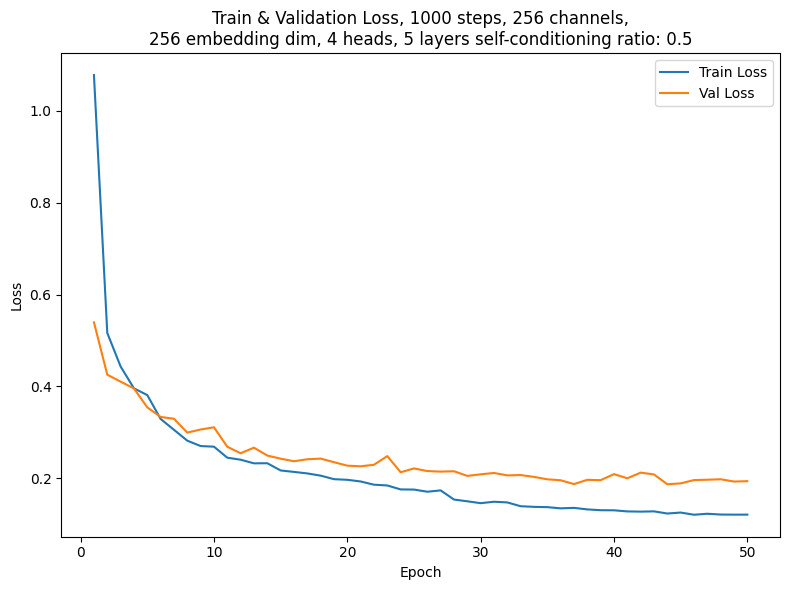

In [3]:

# 4. Train
best_state_dict = None
best_val_loss = float("inf")

train_losses = []
val_losses   = []

for epoch in tqdm(range(1, epochs + 1), desc="Training..."):
    model.train()
    train_noise_mse = 0
    train_noise_nll = 0
    train_frechet_loss = 0
    # train_mse_loss = 0
    # train_dtw_loss = 0
    # train_fde_loss = 0
    train_loss = 0

    for batch in tqdm(train_dataloader, desc = "Batch Training..."):
        cond = batch["condition"].to(device)
        B, T, _ = cond.shape
        target = batch["target"].to(device).view(-1, T, 11, 2)  # [B, T, 11, 2]
        graph_batch = batch["graph"].to(device)                              # HeteroData batch

        # graph → H
        H = graph_encoder(graph_batch)                                       # [B, 128]
        cond_H = H.unsqueeze(-1).unsqueeze(-1).expand(-1, H.size(1), 11, T)
        
        # Target's history trajectories
        hist = cond[:, :, target_idx].to(device) 
        hist_rep = history_encoder(hist)  # [B, 128]
        cond_hist = hist_rep.unsqueeze(-1).unsqueeze(-1).expand(-1, H.size(1), 11, T)
        
        # Concat conditions
        cond_info = torch.cat([cond_H, cond_hist], dim=1)
        # Preparing Self-conditioning data
        # timestep (consistency)
        t = torch.randint(0, model.num_steps, (target.size(0),), device=device)
        if torch.rand(1, device=device) < self_conditioning_ratio:
            with torch.no_grad():
                x_t, noise = model.q_sample(target, t)
                x_t = x_t.permute(0,3,2,1)
                
                z1 = model.model(x_t, t, cond_info, self_cond=None)
                
                eps_pred1 = z1[:, :2, :, :]
                a_hat = model.alpha_hat.to(device)[t].view(-1,1,1,1)
                x0_hat = (x_t - (1 - a_hat).sqrt() * eps_pred1) / a_hat.sqrt()
                x0_hat = x0_hat.permute(0,3,2,1)
                                
            s = x0_hat
        else:
            s = torch.zeros_like(target)

        
        # noise_loss, player_loss_mse, player_loss_frechet = model(target, cond_info=cond_info, self_cond=s)
        # loss = noise_loss + player_loss_mse + player_loss_frechet * 0.2
        noise_mse, noise_nll, player_frechet_loss = model(target, t=t, cond_info=cond_info, self_cond=s)
        loss = noise_mse + noise_nll * 0.005 + player_frechet_loss * 0.1
            
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # train_noise_loss += (noise_loss).item()
        # train_mse_loss += (player_loss_mse).item()
        # train_dtw_loss += (player_loss_dtw).item()
        # train_fde_loss += (player_loss_fde).item()
        train_noise_mse += (noise_mse).item()
        train_noise_nll += (noise_nll * 0.005).item()
        train_frechet_loss += (player_frechet_loss * 0.1).item()
        train_loss += loss.item()

    num_batches = len(train_dataloader)
    
    # avg_noise_loss = train_noise_loss / num_batches
    # # avg_mse_loss = train_mse_loss / num_batches
    # avg_dtw_loss = train_dtw_loss / num_batches
    # avg_fde_loss = train_fde_loss / num_batches
    avg_train_noise_mse = train_noise_mse / num_batches
    avg_train_noise_nll = train_noise_nll / num_batches
    avg_train_frechet_loss = train_frechet_loss / num_batches
    avg_train_loss = train_loss / num_batches


    # --- Validation ---
    model.eval()
    # val_noise_loss = 0
    # val_mse_loss = 0
    # val_dtw_loss = 0
    # val_fde_loss = 0
    val_noise_mse = 0
    val_noise_nll = 0
    val_frechet_loss = 0
    val_total_loss = 0

    with torch.no_grad():
        for batch in tqdm(val_dataloader, desc="Validation"):
            cond = batch["condition"].to(device)
            B, T, _ = cond.shape
            target = batch["target"].to(device).view(-1, T, 11, 2)  # [B, T, 11, 2]
            graph_batch = batch["graph"].to(device)                              # HeteroData batch

            # graph → H
            H = graph_encoder(graph_batch)                                       # [B, 128]
            cond_H = H.unsqueeze(-1).unsqueeze(-1).expand(-1, H.size(1), 11, T)
            
            # Target's history trajectories
            hist = cond[:, :, target_idx].to(device)  # [B,128,11,T]
            hist_rep = history_encoder(hist)  # [B, 128]
            cond_hist = hist_rep.unsqueeze(-1).unsqueeze(-1).expand(-1, H.size(1), 11, T)
            
            # Concat conditions
            cond_info = torch.cat([cond_H, cond_hist], dim=1)
            
            s = torch.zeros_like(target)
            
            # noise_loss, player_loss_mse, player_loss_frechet = model(target, cond_info=cond_info, self_cond=s)
            # val_loss = noise_loss + player_loss_mse + player_loss_frechet * 0.2
            noise_mse, noise_nll, player_frechet_loss = model(target, cond_info=cond_info, self_cond=s)
            val_loss = noise_mse + noise_nll * 0.005 + player_frechet_loss * 0.1
        
            # val_noise_loss += (noise_loss).item()
            # # val_mse_loss += (player_loss_mse).item()
            # val_dtw_loss += (player_loss_dtw).item()
            # val_fde_loss += (player_loss_fde).item()
            val_noise_mse += (noise_mse).item()
            val_noise_nll += (noise_nll * 0.005).item()
            val_frechet_loss += (player_frechet_loss * 0.1).item()
            val_total_loss += val_loss.item()

    # avg_val_noise_loss = val_noise_loss / len(val_dataloader)
    # # avg_val_mse_loss = val_mse_loss / len(val_dataloader)
    # avg_val_dtw_loss = val_dtw_loss / len(val_dataloader)
    # avg_val_fde_loss = val_fde_loss / len(val_dataloader)
    # avg_val_loss = val_total_loss / len(val_dataloader)
    
    num_batches = len(val_dataloader)
    
    avg_val_noise_mse = val_noise_mse / num_batches
    avg_val_noise_nll = val_noise_nll / num_batches
    avg_val_frechet_loss = val_frechet_loss / num_batches
    avg_val_loss = val_total_loss / num_batches
  
    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)
    
    current_lr = scheduler.get_last_lr()[0]
    logger.info(f"[Epoch {epoch}/{epochs}] Train Loss={avg_train_loss:.6f} (Noise simple={avg_train_noise_mse:.6f}, Noise NLL={avg_train_noise_nll:.6f}, Frechet={avg_train_frechet_loss:.6f}) |"
                f"Val Loss={avg_val_loss:.6f} | LR={current_lr:.6e}")
    
    tqdm.write(f"[Epoch {epoch}]\n"
               f"[Train] Cost: {avg_train_loss:.6f} | Noise Loss: {avg_train_noise_mse:.6f} | NLL Loss: {avg_train_noise_nll:.6f} | Frechet: {avg_train_frechet_loss:.6f} | LR: {current_lr:.6f}\n"
               f"[Validation] Val Loss: {avg_val_loss:.6f} | Noise Loss: {avg_val_noise_mse:.6f} | NLL Loss: {avg_val_noise_nll:.6f} | Frechet: {avg_val_frechet_loss:.6f} |")
    
    scheduler.step(avg_val_loss)
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        best_state_dict = model.state_dict()

logger.info(f"Training complete. Best val loss: {best_val_loss:.6f}")
        
# 4-1. Plot learning_curve
plt.figure(figsize=(8, 6))
plt.plot(range(1, epochs+1), train_losses, label='Train Loss')
plt.plot(range(1, epochs+1), val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title(f"Train & Validation Loss, {csdi_config['num_steps']} steps, {csdi_config['channels']} channels,\n"
          f"{csdi_config['diffusion_embedding_dim']} embedding dim, {csdi_config['nheads']} heads, {csdi_config['layers']} layers "
          f"self-conditioning ratio: {self_conditioning_ratio}")
plt.legend()
plt.tight_layout()

plt.savefig('results/0513_diffusion_lr_curve.png')

plt.show()

In [ ]:

# 5. Inference (Best-of-N Sampling) & Visualization
model.load_state_dict(best_state_dict)
model.eval()
all_best_ades_test = []
all_best_fdes_test = []
ddim_steps_list = [10, 20, 30, 40, 50, 100, 200, 500, 1000]
visualize_samples = 5
visualized = False

with torch.no_grad():
    for batch in tqdm(test_dataloader, desc="Test Streaming Inference"):
        cond = batch["condition"].to(device)
        B, T, _ = cond.shape
        target = batch["target"].to(device).view(B, T, 11, 2)

        graph_batch  = batch["graph"].to(device)
        H = graph_encoder(graph_batch)
        cond_H = H.unsqueeze(-1).unsqueeze(-1).expand(-1, H.size(1), 11, T)
        
        hist = cond[:, :, target_idx].to(device)
        hist_rep = history_encoder(hist)
        cond_hist = hist_rep.unsqueeze(-1).unsqueeze(-1).expand(-1, H.size(1), 11, T)
        cond_info = torch.cat([cond_H, cond_hist], dim=1)

        best_ade_t = torch.full((B,), float("inf"), device=device)
        best_pred_t = torch.zeros_like(target)
        best_fde_t = torch.full((B,), float("inf"), device=device)
                    
        scales = torch.tensor(batch["pitch_scale"], device=device, dtype=torch.float32)  
        scales = scales.view(B, 1, 1, 2)

        for _ in tqdm(range(num_samples), desc="Generating..."):
            pred_i = model.generate(shape=target.shape, cond_info=cond_info, ddim_steps=ddim_step, eta=eta, num_samples=1)[0]

            pred_i_den = pred_i * scales
            target_den = target * scales
            
            ade_i = ((pred_i_den - target_den)**2).sum(-1).sqrt().mean((1,2))
            fde_i = ((pred_i_den[:,-1] - target_den[:,-1])**2).sum(-1).sqrt().mean(1)
            
            better = ade_i < best_ade_t
            
            best_pred_t[better] = pred_i_den[better]
            best_ade_t[better] = ade_i[better]
            best_fde_t[better] = fde_i[better]

        all_best_ades_test.extend(best_ade_t.cpu().tolist())
        all_best_fdes_test.extend(best_fde_t.cpu().tolist())

        # —— 여기부터 시각화 로직 확장 —— 
        if not visualized:
            base_dir = "results/test_trajs/"
            os.makedirs(base_dir, exist_ok=True)
            
            # batch 내에서 최대 visualize_samples 개 샘플만 처리
            for i in range(min(B, visualize_samples)):
                # 샘플별 폴더
                sample_dir = os.path.join(base_dir, f"sample{i:02d}")
                os.makedirs(sample_dir, exist_ok=True)

                # 공·공격수 궤적, 실제 수비수 궤적
                others_seq  = batch["other"][i].view(T, 12, 2).cpu().numpy()
                target_traj = (target[i] * scales[i]).cpu().numpy()

                # 각 DDIM step 별 생성 궤적
                for steps in ddim_steps_list:
                    # 1) 한 번 샘플링
                    pred_steps = model.generate(
                        shape=target.shape,
                        cond_info=cond_info[i:i+1],      # 이 배치의 i번째만
                        ddim_steps=steps,
                        eta=eta,
                        num_samples=1
                    )[0, 0]  # [T, 11, 2]
                    pred_steps_den = (pred_steps * scales[i].cpu()).cpu().numpy()

                    # 2) 선수별로 저장
                    for p in range(pred_steps_den.shape[1]):
                        jersey = int(batch["target_columns"][i][2*p].split("_")[1])
                        save_path = os.path.join(
                            sample_dir,
                            f"ddim_steps={steps}/player_{jersey:02d}_ddim{steps}.png"
                        )
                        plot_trajectories_on_pitch(
                            others_seq,
                            target_traj,
                            pred_steps_den,
                            other_columns = batch["other_columns"][i],
                            target_columns = batch["target_columns"][i],
                            player_idx = p,
                            annotate = True,
                            save_path = save_path
                        )

            visualized = True
            
            print(all_best_ades_test)
            print(all_best_fdes_test)
avg_test_ade = np.mean(all_best_ades_test)
avg_test_fde = np.mean(all_best_fdes_test)
print(f"[Test Best-of-{num_samples}] Average ADE: {avg_test_ade:.4f} | Average FDE: {avg_test_fde:.4f}")
print(f"[Test Best-of-{num_samples}] Best ADE overall: {min(all_best_ades_test):.4f} | Best FDE overall: {min(all_best_fdes_test):.4f}")
print(f"[Test Best-of-{num_samples}] Worst ADE overall: {max(all_best_ades_test):.4f} | Worst FDE overall: {max(all_best_fdes_test):.4f}")
print(f"[Test Best-of-{num_samples}] STD of ADE overall: {np.std(all_best_ades_test):.4f} | STD FDE overall: {np.std(all_best_fdes_test):.4f}")

Test Streaming Inference:   0%|          | 0/98 [00:59<?, ?it/s]

Generating...:   0%|          | 0/10 [00:00<?, ?it/s]

[24.873382568359375, 24.616121292114258, 23.386613845825195, 22.866296768188477, 22.260896682739258, 22.32654571533203, 22.087318420410156, 22.249561309814453, 22.308937072753906, 21.93429183959961, 22.10972023010254, 21.883024215698242, 22.8346004486084, 22.577770233154297, 23.221086502075195, 23.252880096435547]
[33.635799407958984, 32.116485595703125, 26.849105834960938, 29.92003631591797, 26.64061164855957, 25.863393783569336, 23.472917556762695, 25.187728881835938, 21.597471237182617, 23.903751373291016, 23.12775230407715, 22.218246459960938, 22.7592716217041, 24.770742416381836, 26.104049682617188, 25.063615798950195]


Generating...:   0%|          | 0/10 [00:00<?, ?it/s]

Generating...:   0%|          | 0/10 [00:00<?, ?it/s]

Generating...:   0%|          | 0/10 [00:00<?, ?it/s]

Generating...:   0%|          | 0/10 [00:00<?, ?it/s]

Generating...:   0%|          | 0/10 [00:00<?, ?it/s]

Generating...:   0%|          | 0/10 [00:00<?, ?it/s]

Generating...:   0%|          | 0/10 [00:00<?, ?it/s]

Generating...:   0%|          | 0/10 [00:00<?, ?it/s]

Generating...:   0%|          | 0/10 [00:00<?, ?it/s]

Generating...:   0%|          | 0/10 [00:00<?, ?it/s]

Generating...:   0%|          | 0/10 [00:00<?, ?it/s]

Generating...:   0%|          | 0/10 [00:00<?, ?it/s]

Generating...:   0%|          | 0/10 [00:00<?, ?it/s]

Generating...:   0%|          | 0/10 [00:00<?, ?it/s]

Generating...:   0%|          | 0/10 [00:00<?, ?it/s]

Generating...:   0%|          | 0/10 [00:00<?, ?it/s]

Generating...:   0%|          | 0/10 [00:00<?, ?it/s]

Generating...:   0%|          | 0/10 [00:00<?, ?it/s]

Generating...:   0%|          | 0/10 [00:00<?, ?it/s]

Generating...:   0%|          | 0/10 [00:00<?, ?it/s]

Generating...:   0%|          | 0/10 [00:00<?, ?it/s]

Generating...:   0%|          | 0/10 [00:00<?, ?it/s]

Generating...:   0%|          | 0/10 [00:00<?, ?it/s]

Generating...:   0%|          | 0/10 [00:00<?, ?it/s]

Generating...:   0%|          | 0/10 [00:00<?, ?it/s]

Generating...:   0%|          | 0/10 [00:00<?, ?it/s]

Generating...:   0%|          | 0/10 [00:00<?, ?it/s]

Generating...:   0%|          | 0/10 [00:00<?, ?it/s]

Generating...:   0%|          | 0/10 [00:00<?, ?it/s]

Generating...:   0%|          | 0/10 [00:00<?, ?it/s]

Generating...:   0%|          | 0/10 [00:00<?, ?it/s]

Generating...:   0%|          | 0/10 [00:00<?, ?it/s]

Generating...:   0%|          | 0/10 [00:00<?, ?it/s]

Generating...:   0%|          | 0/10 [00:00<?, ?it/s]

Generating...:   0%|          | 0/10 [00:00<?, ?it/s]

Generating...:   0%|          | 0/10 [00:00<?, ?it/s]

Generating...:   0%|          | 0/10 [00:00<?, ?it/s]

Generating...:   0%|          | 0/10 [00:00<?, ?it/s]

Generating...:   0%|          | 0/10 [00:00<?, ?it/s]

Generating...:   0%|          | 0/10 [00:00<?, ?it/s]

Generating...:   0%|          | 0/10 [00:00<?, ?it/s]

Generating...:   0%|          | 0/10 [00:00<?, ?it/s]

Generating...:   0%|          | 0/10 [00:00<?, ?it/s]

Generating...:   0%|          | 0/10 [00:00<?, ?it/s]

Generating...:   0%|          | 0/10 [00:00<?, ?it/s]

Generating...:   0%|          | 0/10 [00:00<?, ?it/s]

Generating...:   0%|          | 0/10 [00:00<?, ?it/s]

Generating...:   0%|          | 0/10 [00:00<?, ?it/s]

Generating...:   0%|          | 0/10 [00:00<?, ?it/s]

Generating...:   0%|          | 0/10 [00:00<?, ?it/s]

Generating...:   0%|          | 0/10 [00:00<?, ?it/s]